## 문제: 전복 나이의 예측: sklearn, spark 회귀분석

전복의 나이를 예측하는 문제이다.
전복은 껍질에 둥근 테 ring이 있는데, 이를 보고 나이를 판별할 수 있다.
이런 둥근 테의 갯수에 1.5를 더하면 계산할 수 있다 (Mayukh, 2010).
전복은 암치와 수치가 서식지가 서로 달라 먹이가 다르기 때문에, 내장의 색이 다르다. 내장 색이 짙은 녹색이면 암치, 황색이면 수치이다. 
전복의 성별 및 크기 관련 정보를 가지고 rings에 대해 회귀식을 도출해보자.
* (1) url에서 데이터 읽기
* (2) 기초통계
* (3) 상관관계
* (4) sklearn으로 회귀분석, 정확성
* (5) spark로 회귀분석, 정확성

참고:
* Mayukh, H. (2010). Age of Abalones using Physical Characteristics: A Classification Problem. ECE 539 Fall 2010 Project Report University of Wisconsin-Madison, 1-4.
* https://www.kaggle.com/ragnisah/eda-abalone-age-prediction

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

### (1) 데이터 읽기

데이터는 UCI Machine Learning Repository에서 제공하고, 전복관련 데이터 총 4177 건이 저장되어 있다.
변수는 sex, length, diameter, height, whole weight, shucked weight, viscera weight, shell weight, rings이고,
마지막 **rings 갯수**가 예측해야 하는 종속변수이다.

아래 URL을 웹브라우저에서 열면, 파일이 자동으로 내려받게 된다.
우리는 파일을 내려받지 않고, URL에서 데이터를 바로 읽게 된다.

In [12]:
file_name="http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

In [13]:
import pandas as pd

column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone = pd.read_csv(file_name, names=column_names)

In [14]:
abalone.head() # 성별: 명목변수 -> 회귀에 넣으면 성별에 다라 rings에 영향?

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### 나이계산

나이는 rings에 1.5를 곱해서 구한다.

In [15]:
abalone["age"] = 1.5 * abalone["rings"]

무작위로 데이터를 선별해서 잘 읽혔는지 보자.

In [16]:
abalone.sample(n=5) #랜덤으로 몇개 뽑아보기

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age
2178,F,0.595,0.480,0.20,0.9750,0.358,0.2035,0.3400,15,22.5
2609,F,0.630,0.495,0.20,1.4255,0.659,0.3360,0.3800,11,16.5
3953,I,0.465,0.355,0.12,0.5805,0.255,0.0915,0.1840,8,12.0
191,M,0.610,0.485,0.17,1.0225,0.419,0.2405,0.3600,12,18.0
2932,M,0.615,0.455,0.15,0.9335,0.382,0.2470,0.2615,10,15.0


### (2) 기초통계

회귀분석을 하기전, 기술통계를 데이터의 성격을 살펴보는 것이 필요하다.  
**rings** 갯수는 1 ~ 29 정도로 분포되어 있다 
데이터 갯수가 4177로 일치하는지, 그렇지 않다면 결측 값이 있다는 것이다.
평균, 표준편차, 최대, 최소를 보면서 outlier를 확인한다.
**특이하게 height가 0**인 경우가 있다.

In [17]:
abalone.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,14.900527
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,4.836254
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,1.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,12.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,13.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,16.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,43.500000


height가 없는 경우를 살펴보자.
이 경우 데이터가 0인 이유를 알 수 없는 경우, (1) 평균으로 대체하거나, (2) 모두 결측으로 처리할 수 있다.
여기서는 모두 제거한다.

In [18]:
abalone = abalone[abalone['height']>0] #4177->4175

In [20]:
abalone.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090,14.902635
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227,4.836341
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,1.500000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000,12.000000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,13.500000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000,16.500000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,43.500000


### (3) 상관관계

상관관계는 서로 어떤 관계가 있는지 보여준다. 반면에 회귀식은 독립변수가 종속변수에 영향을 주는 관계를 나타낸다.
상관관계의 방향성과 강도에 따라 회귀식에서 그 변수가 가중치를 결정하는데 영향을 미치게 된다.

#### Pairplot
seaborn에서 제공하는 pairplot은 변수 간 상관관계를 시각화하여 준다.
seaborn은 그 자체로는 그래프를 그릴 수 없다.
matplotlib을 기반으로 하기 때문에 이를 import하고 ```plt.show()```
**hue**는 변수명을 선택하여 다른 색으로 그래프를 나타낸다.
이때 **diag_kind**를 ‘auto’, ‘hist’, ‘kde’ 가운데서 고르거나, 선택적 optional으로 정의하여 모양을 다르게 할 수 있다.

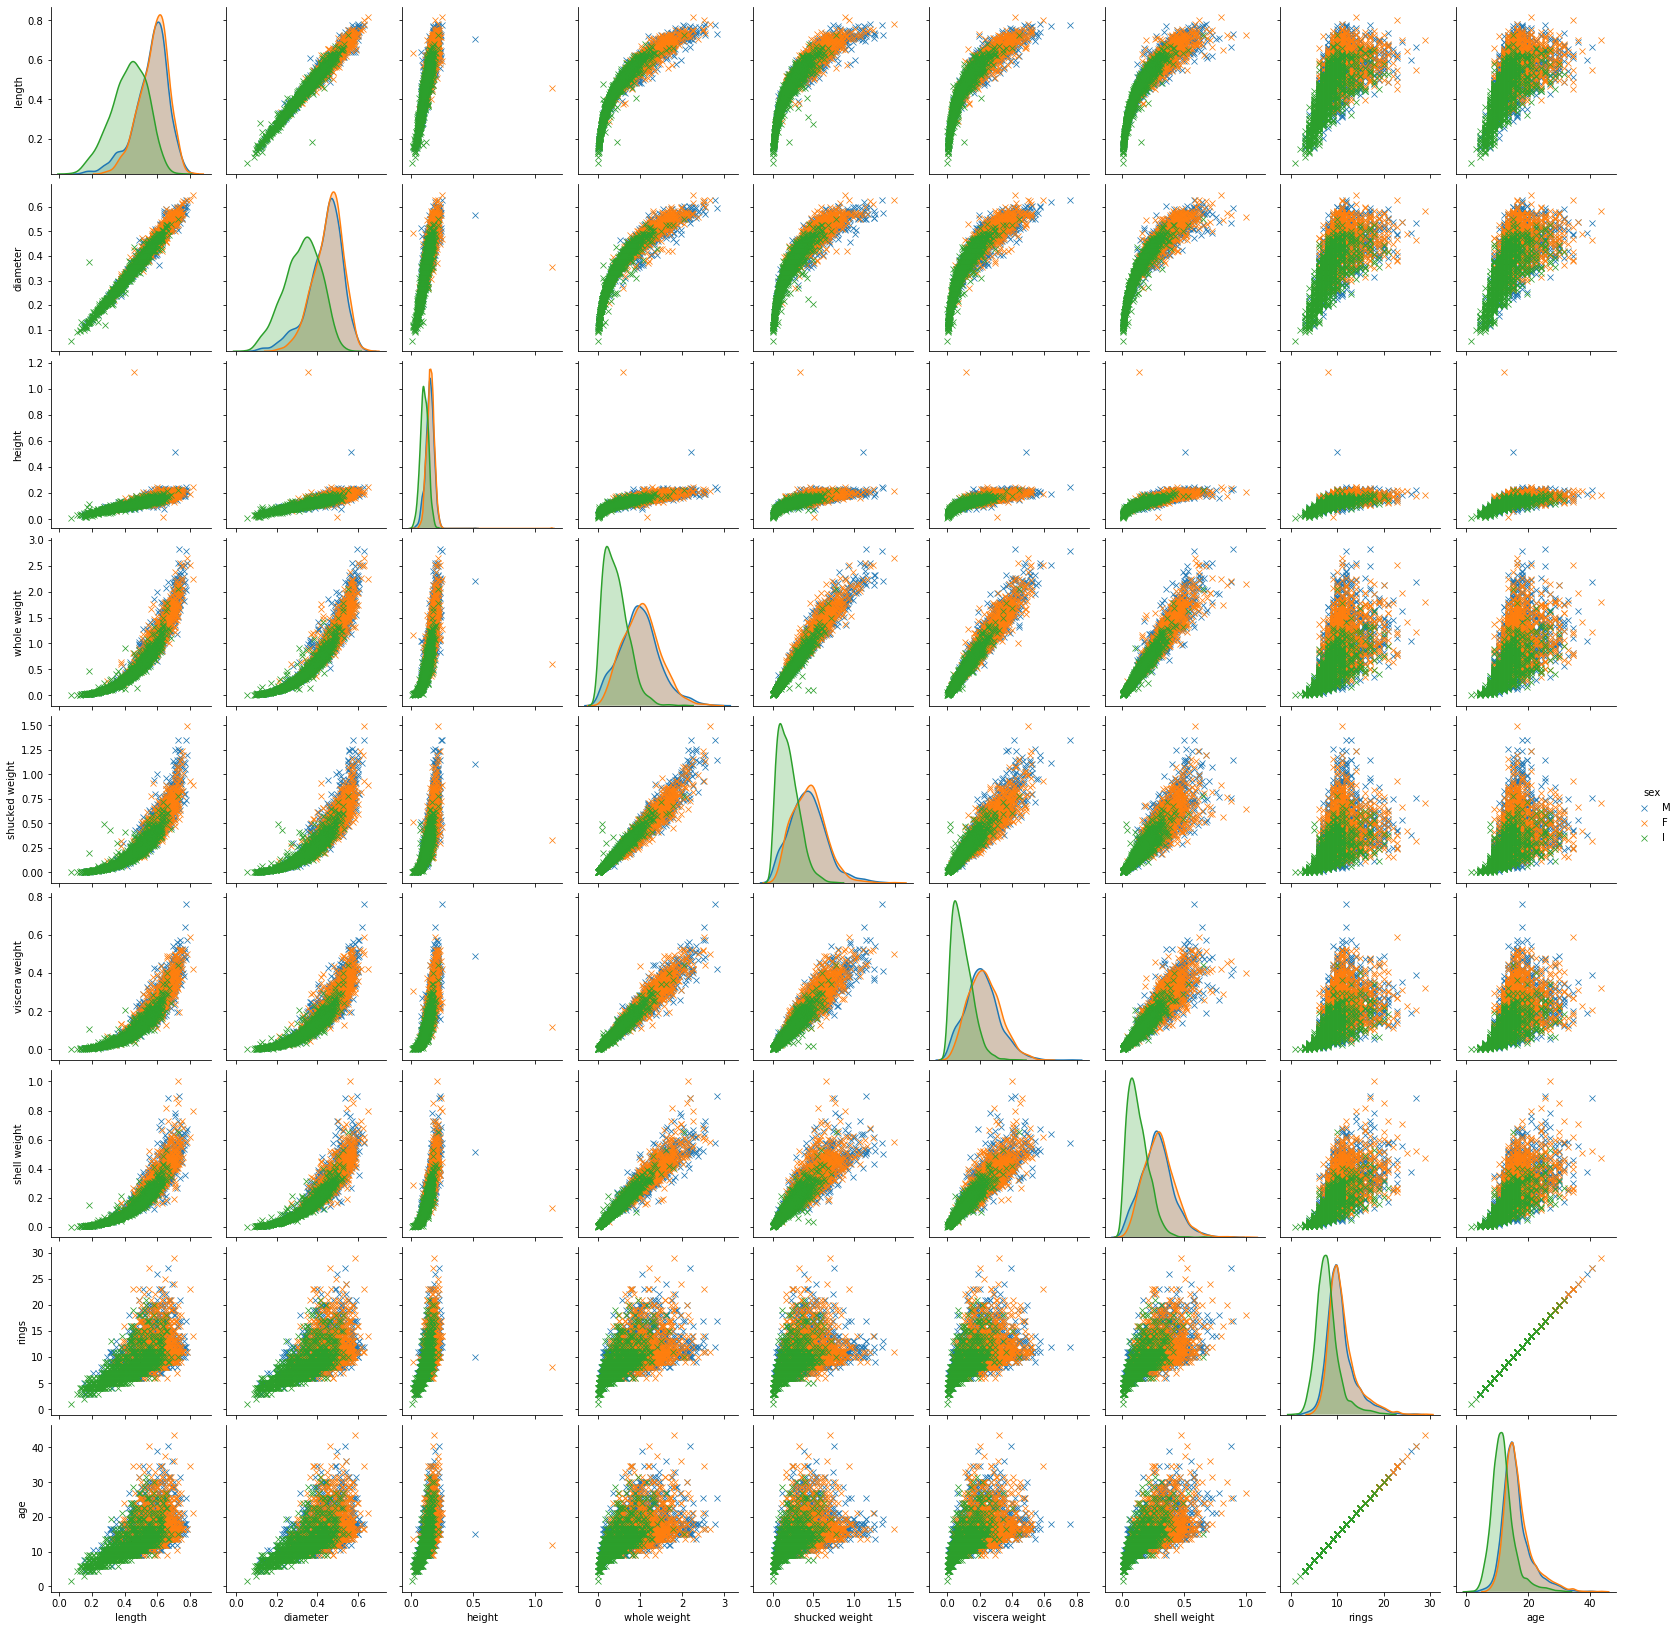

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(abalone, hue='sex', markers='x', diag_kind="kde") #성별을 기준으로 색상을 다르게, x로 마크
#plt.show()

#### heatmap

heatmap은 상관관계의 강도에 따라 색을 다르게 나타내게 된다.

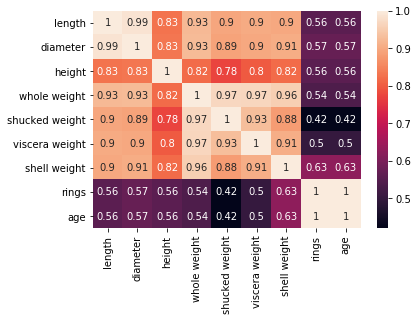

In [22]:
%matplotlib inline
corr = abalone.corr()
sns.heatmap(corr, annot=True) #correlation이 작으면 그걸 빼고 해도 상관없을듯?, 보기 위하여 히트맵으로 표현
#plt.show()

### (4) Sklearn

회귀분석의 입력변수에 명목변수가 있다면, 그대로 사용할 수 없다.

#### 독립변수, 종속변수 준비
#### 명목변수 변환

'sex'는 명목변수이다. 각 각의 값에 대해 **dummy 변수** Male, Female, Infant(유아)로 변환한다.  
성별 또는 학위구분 같은 명목변수는 회귀식에 0,1의 값을 가지는 **dummy 변수**로 변환해서 사용한다.

```python
sex        Male Female Infant
M          1     0     0
M       -> 1     0     0
F          0     1     0
M          1     0     0
I          0     0     1
```

#### Python으로 명목변수 처리

In [23]:
abalone['Male'] = (abalone['sex']=='M').astype(int)
abalone['Female'] = (abalone['sex']=='F').astype(int)
abalone['Infant'] = (abalone['sex']=='I').astype(int)

#### Sklearn OneHotEncoder

One-Hot Encoding은 명목변수를 이진벡터로 변환한다. 명목변수를 정수로 변환하게 되면, 예를 들어 M을 0, F를 1, I를 2로 설정하면 서로 순서가 있는 것으로 보일 수 있다. 이진벡터로 변환하면 이런 순서가 없도록 한다.

sklearn 0.22부터 특정 명목변수의 컬럼만 선택하여 ```OneHotEncoder(categorical_features = [0])``` 을 사용하지 못하게 되었고, ```sklearn.compose.ColumnTransformer```를 사용해야 한다.

* 우선 transformers는 (Name, Object, Columns)로 정해준다.
```[("sex", OneHotEncoder(handle_unknown='ignore'), [0])]```
    * '0'은 명목변수에 해당하는 컬럼의 인덱스이다.
    * ```handle_unknown```는 명목변수에 모르는 값이 존재할 경우, 무시 'ignore' 하라는 의미다.
* 명목변수가 아닌 다른 컬럼 remainder는 변환 없이 그냥 통과 'passthrough' (기본은 'drop'이다).


In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[("sex", OneHotEncoder(handle_unknown='ignore'), [0])],
                       remainder = 'passthrough')
X = ct.fit_transform(abalone)

In [25]:
_abalone = pd.DataFrame(X)

In [26]:
_abalone.describe() #header가 없어졌다

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.313054,0.320958,0.365988,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090,14.902635,0.365988,0.313054,0.320958
std,0.463792,0.466901,0.481764,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227,4.836341,0.481764,0.463792,0.466901
min,0.000000,0.000000,0.000000,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,1.500000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000,12.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,13.500000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000,16.500000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,43.500000,1.000000,1.000000,1.000000


### 회귀분석
#### 훈련, 테스트 데이터 분리

앞서 Python으로 만든 명목변수 컬럼을 사용하여 회귀분석을 하자.
데이터를 일정 비율로 train, test로 나눈다.
train은  회귀식을 결정하기 위해 모델링에 사용한다. 반면에 test는 train된 모델이 잘 만들어졌는지 정확성을 분석할 때 적용되는 데이터이다.
train에 60%, test에 40%의 데이터를 분할한다.

In [46]:
#from sklearn.cross_validation import train_test_split # sklearn old version
from sklearn.model_selection import train_test_split

train, test = train_test_split(abalone, train_size=0.6)

종속변수인 age는 별도로 저장하고, 명목변수 sex와 rings는 제거하자.
(xtrain, ytrain)과 (xtest, ytest) 한 쌍으로 데이터를 준비한다.

In [47]:
from sklearn import linear_model

xtrain = train.drop(['age','rings','sex'],axis=1)
ytrain = train['age']
xtest = test.drop(['age','rings','sex'],axis=1)
ytest = test['age']

train, test 데이터의 컬럼이 원하는대로 포함되었는지 확인해보자.
60%의 갯수와 컬럼이 포함되어 있다는 것을 확인할 수 있다.

In [48]:
xtrain.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,Male,Female,Infant
3306,0.410,0.300,0.115,0.2595,0.0970,0.0515,0.0800,0,0,1
1499,0.630,0.470,0.145,1.1005,0.5200,0.2600,0.2760,1,0,0
1206,0.750,0.570,0.210,2.2360,1.1090,0.5195,0.5450,0,1,0
909,0.335,0.250,0.075,0.1860,0.0945,0.0380,0.0445,0,0,1
3857,0.655,0.515,0.200,1.3730,0.4430,0.3375,0.4900,1,0,0


#### 회귀모델링

In [49]:
regression = linear_model.LinearRegression()
trainModel = regression.fit(xtrain, ytrain)

절편과 계수를 출력해보자.

In [50]:
trainModel.intercept_

4.7644897349699615

In [51]:
trainModel.coef_

array([  3.71750112,   8.74698222,  32.97086877,  11.29401211,
       -27.44737835, -14.58038311,  12.95134292,   0.56173306,
         0.38047559,  -0.94220865])

컬럼명과 계수를 같이 붙여서 보면 편리하다.

In [52]:
list(zip(xtrain.columns,regression.coef_))

[('length', 3.717501120804585),
 ('diameter', 8.746982217264945),
 ('height', 32.97086876944809),
 ('whole weight', 11.294012108255199),
 ('shucked weight', -27.447378345247433),
 ('viscera weight', -14.580383107751388),
 ('shell weight', 12.951342917056154),
 ('Male', 0.561733058769788),
 ('Female', 0.38047558643139867),
 ('Infant', -0.9422086452010348)]

#### 정확성

방금 도출한 선형회귀식의 정확성을 계산해보자.
앞서 분리해 놓은 xtest, ytest에 적용한다.

In [53]:
# Explained variance score: 1 is perfect prediction
accuracy = regression.score(xtest,ytest)

In [54]:
f"accuracy: {accuracy*100:.2f}%"

'accuracy: 52.77%'

예측값과 실제값을 비교해보자.

In [55]:
ypred = regression.predict(xtest)

```flatten()```함수는 배열을 1차원으로 만들어 준다.

In [56]:
#_df = pd.DataFrame({'Actual': ytest, 'Predicted': ypred.flatten()})
y_actual_pred = pd.DataFrame({'Actual': ytest, 'Predicted': ypred.flatten()})

실제 Actual과 예측 Predicted를 비교해보자. 518번째의 경우 그 차이가 크게 나왔고 나머지는 비교적 정확하게 예측되었다.

In [57]:
y_actual_pred.head()

,Actual,Predicted
568,10.5,11.002158
1117,12.0,13.332342
3108,10.5,10.578988
658,27.0,18.608138
1445,9.0,10.591565


MSE 평균제곱오류를 계산해보자.

In [58]:
import numpy as np

print("Mean Squared Error: %.2f" % np.mean((regression.predict(xtest) - ytest) ** 2))

Mean Squared Error: 11.58


$R^2$을 계산해보자.

In [59]:
from sklearn.metrics import r2_score

r2 = r2_score(ytest, ypred )
f"r2: {r2:.3f}"

'r2: 0.528'

#### 그래프

아래 그림은 예측값 ypred, 실제값 ytest의 산포도를 보여주고 있다.
실선은 실제값 ytest이 예측값과 동일한 경우를 말한다. 즉 100% 정확한 경우를 의미한다.
데이터의 후반부는 **예측값이 약간 아래로 분포**함을 보여주고 있다.
이는 보다 정교한 모델링이 필요하다는 의미이다.

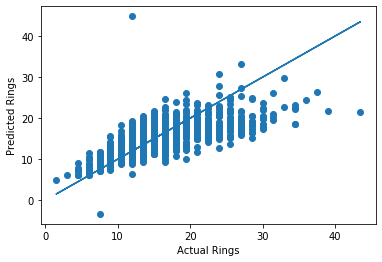

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(ytest,ypred)
ax.set_ylabel('Predicted Rings') 
ax.set_xlabel('Actual Rings')
ax.plot(ytest,ytest) #예측값은 분포가 퍼져있는 것을 확인할 수 있다.

### (5) Spark

이번에는 Spark로 해보자. 앞서 Sklearn과 그 절차와 프로그래밍 코드가 비슷하다.

앞서 만들어 놓았던 4175건의 abalone 데이터를 DataFrame으로 만들어보자.

In [62]:
abalaoneDf=spark.createDataFrame(abalone)

In [64]:
abalaoneDf.printSchema()

root
 |-- sex: string (nullable = true)
 |-- length: double (nullable = true)
 |-- diameter: double (nullable = true)
 |-- height: double (nullable = true)
 |-- whole weight: double (nullable = true)
 |-- shucked weight: double (nullable = true)
 |-- viscera weight: double (nullable = true)
 |-- shell weight: double (nullable = true)
 |-- rings: long (nullable = true)
 |-- age: double (nullable = true)
 |-- Male: long (nullable = true)
 |-- Female: long (nullable = true)
 |-- Infant: long (nullable = true)



#### 성별

In [66]:
abalaoneDf.groupBy('sex').agg({"age":"avg"}).show()

+---+------------------+
|sex|          avg(age)|
+---+------------------+
|  F| 16.69395562356542|
|  M| 16.05824607329843|
|  I|11.837686567164178|
+---+------------------+



#### 훈련, 테스트 데이터 분리

In [67]:
(trainDf, testDf) = abalaoneDf.randomSplit([0.6, 0.4])

무작위로 분리하기 때문에, 분리할 때마다 60%인 2505개와 다소 차이가 있다.

In [69]:
trainDf.count()

2494

#### 회귀모델링

sex는 명목변수이고, 현재 string으로 설정되어 있어서, stringindexer를 거쳐 double타입으로 만들고, 그리고  onehotencoder로 vector로 변환한다.

In [70]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="sex", outputCol="sexIndex")
#siModel = stringIndexer.fit(trainDf)
#siDf = siModel.transform(trainDf)

In [71]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="sexIndex", outputCol="sexVec")
#enModel = encoder.fit(trainDf)
#enDf = enModel.transform(trainDf)

In [72]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["sexVec", "length", "diameter", "height", "whole weight", 
                                            "shucked weight", "viscera weight", "shell weight"],
                                   outputCol = 'features')
#vaDf = va.transform(trainDf)

In [73]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='age', maxIter=10, regParam=0.3, elasticNetParam=0.8)
#lrModel = lr.fit(trainDf)

In [74]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [75]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

#### weights

pipeline을 하고 나면, 단계별 결과를 ```stages[index]```를 통해 알 수 있다.
즉, ```stages[0]```은 stringIndexer, 
```stages[1]```은 다음 단계인 encoder를 접근할 수 있다. 회귀분석은 마지막이므로 ```-1```로 접근하면 된다.

결과는 앞서 Sklearn과 다소 차이가 있다. Spark에서는 무작위로 샘플을 선별하여 train, test를 구성하였기 때문이다.

In [76]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.3718220446411889,0.47936990286212394,1.967372238048848,5.272919186855815,11.259005145284162,0.0,-4.366812184941517,0.0,16.84663734677899]
Intercept: 7.435


#### 예측

앞서 만들었던 trainDf에 대해 만들었던 pipeline 모델을 testDf에 적용한다.

In [77]:
modelTestDf=model.transform(testDf)

아래 결과에서 실제와 예측값의 차이를 볼 수 있다.

In [86]:
modelTestDf.select('age','prediction').show(10)

+----+------------------+
| age|        prediction|
+----+------------------+
| 9.0|10.532410972803564|
|10.5|  11.1413712057608|
| 9.0| 11.30321955472811|
| 9.0|11.510189463958278|
|10.5| 11.69863714233255|
|15.0|11.638357579036796|
| 7.5|11.616774152064007|
|12.0|11.765804075555616|
|10.5|12.221252080033807|
|18.0|12.511854908982635|
+----+------------------+
only showing top 10 rows



### 정확성

In [79]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="rmse")

In [80]:
rmse=evaluator.evaluate(modelTestDf)

In [81]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 3.563'

$R^2$를 계산해보자. 앞서 Sklearn에서는 ```sklearn.metrics.r2_score```를 사용하였지만, metricName만 r2로 교체하자.

In [82]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="r2")

In [83]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.438'